In [18]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

In [69]:
import networkx as nx
from scipy.linalg import expm

Ising Hamiltonian:
$$
H = -J\sum_{j=0}^{d-1}\vec{S}_{j}\cdot\vec{S}_{j+1} = -J/4 \sum_{j=0}^{d-1}(\sigma_{x}^{j}\sigma_{x}^{j+1}+\sigma_{y}^{j}\sigma_{y}^{j+1}+\sigma_{z}^{j}\sigma_{z}^{j+1})
$$
Lets consider the computational basis:
$$
\ket{\{s_{i}\}}
$$
where $i = 0,\ldots,d-1$ and $s_{i} = \pm 1$.

We can distinguish ${n \choose k}$ states with $k$ spins directed upward. The same is for spins directed downward. How ca we find these states that are related by translation?  



Hamitlonian aquires translational symmetry due to the transformation:
$$
\bra{\{s'_{i}\}}T^{\dag} H T \ket{\{s_{i}\}} = \bra{\{s'_{i}\}}H \ket{\{s_{i}\}} 
$$

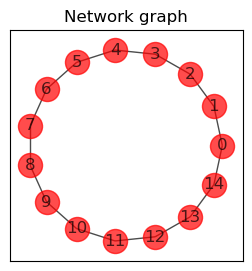

In [110]:
G = nx.Graph()
dim = 15
G.add_nodes_from([str(i) for i in range(dim)])
G.add_edges_from([(str(i),str((i+1)%dim)) for i in range(dim)])

pos = nx.circular_layout(G)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
ax.set_title("Network graph")
nx.draw_networkx(G,ax = ax,pos = pos,node_color = "red",alpha =0.7)

In [19]:
class op:
    sx = np.array([
            [0,1],
            [1,0]
        ])
    sy = np.array([
            [0,-1j],
            [1j,0]
        ])
    sz = np.array([
            [1,0],
            [0,-1]
        ])

In [98]:
def check_two_lists(l1,l2):
    for i in range(len(l1)):
        if l1[i] != l2[i]:
            return False
    return True

class Ising_momentum:
    def __init__(self,dim,J0 = 1):
        self.N = dim
        self.J0 = J0
        self.decide = lambda j,tab :  0 if j in tab else 1

    def group_strings(self,k):
        self.start_group = list(map(lambda el : list(el),combinations([i for i in range(self.N)],k)))
        group = []
        k = 0
        for i in range(len(self.start_group)):
            el = sorted(self.start_group[i])
            group.append([self.start_group[i]])
            el2 = el
            while True:
                el2 = sorted([(i+1)%self.N for i in el2])
                if check_two_lists(el2,el):
                    k+=1
                    break
                else:
                    group[k].append(el2)
        end_group = [group[0]]
        for i in range(1,len(group)):
            answer = True
            for j in range(len(end_group)):
                if group[i][0] in end_group[j]:
                    answer = False
            if answer:
                end_group.append(group[i])
        return end_group
    
    def Hamiltonian(self,bra,ket):
        ans = 0.
        for j in range(self.N):
            decision = list((set(bra)-set(ket)).union(set(ket)-set(bra)))
            ans_temp = 0.
            if j in decision:
                decision.remove(j)
            if (j+1)%self.N in decision:
                decision.remove((j+1)%self.N)
            if len(decision) == 0:
                ans_temp += op.sz[self.decide(j,bra),self.decide(j,ket)]*op.sz[self.decide((j+1)%self.N,bra),self.decide((j+1)%self.N,ket)]
                ans_temp += op.sy[self.decide(j,bra),self.decide(j,ket)]*op.sy[self.decide((j+1)%self.N,bra),self.decide((j+1)%self.N,ket)]
                ans_temp += op.sx[self.decide(j,bra),self.decide(j,ket)]*op.sx[self.decide((j+1)%self.N,bra),self.decide((j+1)%self.N,ket)]
            ans += ans_temp
        return ans
            
    def momentum_Hamiltonian(self,k):
        reference_list = self.group_strings(k)
        H_k = []
        for i in range(len(reference_list)):
            dim = len(reference_list[i])
            H_k_temp = np.zeros((dim,dim),dtype=complex)
            for m in range(dim):
                for n in range(dim):
                    H_k_temp[m,n] = self.J0 * self.Hamiltonian(reference_list[i][m],reference_list[i][n])
            H_k.append(H_k_temp)
        return H_k
    
    def get_eigen(self):
        Eigen = []
        for k in range(self.N+1):
            mH = self.momentum_Hamiltonian(k)
            for l in range(len(mH)):
                Eigen.append(np.linalg.eig(mH[l])[0])
        return np.concatenate(Eigen)

In [148]:
def vis(model,ax1,ax2,ax3,color = "red"):
    E = np.real(model.get_eigen())
    U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))

    T = np.arange(0.01,10,0.01)
    U_T = np.vectorize(U)(T)

    ax1.plot(T,U_T,color = color,alpha = 0.5,lw = 2)
    ax1.set_ylabel("U(T)")

    ax2.plot(T,np.gradient(U_T),color = color,alpha = 0.5,lw = 2)
    ax2.set_ylabel(r"$\frac{\partial U}{\partial T}$")

    ax3.scatter(range(len(E)),np.sort(E),color = color,alpha = 1,s=2)
    ax3.set_ylabel(r"$Energy$")
    ax3.grid(True)

    axs = [ax1,ax2]
    for ax in axs:
        ax.grid(True)
        ax.set_xlabel("T")

/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_866/309699010.py:3: RuntimeWarning: overflow encountered in exp
  U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))
/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_866/309699010.py:3: RuntimeWarning: invalid value encountered in scalar divide
  U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))


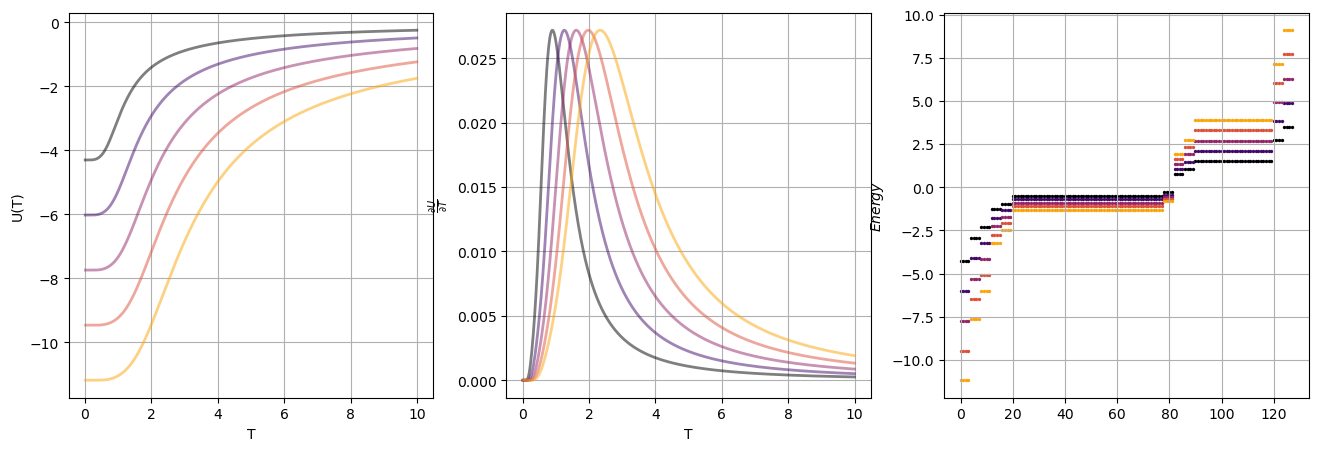

In [154]:
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


J0 = np.arange(0.5,1.5,0.2)
inferno = plt.cm.inferno
colors = [inferno(i/len(J0)) for i in range(len(J0))]
for j0 in range(len(J0)):
    model = Ising_momentum(7,J0[j0])
    vis(model,ax1,ax2,ax3,colors[j0])

plt.show()

Modified Hamiltonian
$$
H =J_{1}/4 \sum_{j=0}^{d-1}\vec{\sigma}^{(j)}\cdot \vec{\sigma}^{(j+1)} +J_{2}/4 \sum_{j=0}^{d-1}\vec{\bar{\sigma}}^{(j)}\cdot \vec{\bar{\sigma}}^{(j+1)} +\eta/4 \sum_{j=0}^{d-1}\vec{\bar{\sigma}}^{(j)}\cdot (\vec{\sigma}^{(j)} + \vec{\sigma}^{(j+1)})
$$

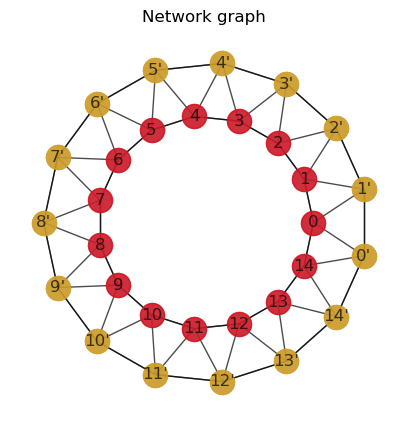

In [150]:
G = nx.Graph()
dim = 15
G.add_nodes_from([str(i) for i in range(dim)])
G.add_nodes_from([str(i) + "'" for i in range(dim)])
G.add_edges_from([(str(i),str((i+1)%dim)) for i in range(dim)])
G.add_edges_from([(str(i)+ "'",str((i+1)%dim)+"'") for i in range(dim)])
G.add_edges_from([(str(i),str((i+1)%dim)+"'") for i in range(dim)])
G.add_edges_from([(str(i),str(i)+"'") for i in range(dim)])

subG1 = G.subgraph([str(i) for i in range(dim)])
subG2 = G.subgraph([str(i) + "'" for i in range(dim)])

pos = nx.circular_layout(subG1)
pos2 = nx.circular_layout(subG2)
for key in pos2.keys():
    pos2[key] *= 1.5
    pos2[key] = np.real(expm(1j* op.sy* np.pi / dim) @ pos2[key])

pos_general = {**pos,**pos2}

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.set_title("Network graph")
nx.draw(G,ax=ax,pos = pos_general,alpha = 0.7)
nx.draw_networkx(subG1,ax = ax,pos = pos,node_color = "red",alpha =0.7)
nx.draw_networkx(subG2,ax = ax,pos = pos2,node_color = "orange",alpha =0.7)

In [ ]:
class Ising_momentum_2layers(Ising_momentum):
    def __init__(self,dim,J0,J1,eta):
        super().__init__(dim,J0)
        self.J1 = J1
        self.eta = eta

    def get_sub_Hamiltonian(self,bra,ket,bra1,ket1):
        decision = (set(bra1)-set(ket1)).union(set(ket1)-set(bra1))
        if len(decision) != 0 :
            return 0,decision
        return super().Hamiltonian(bra, ket),decision

    def Hamiltonian(self,bra0,ket0,bra1,ket1):
        ans0,decision0 = self.get_sub_Hamiltonian(bra0,ket0,bra1,ket1)
        ans1,decision1 = self.get_sub_Hamiltonian(bra1,ket1,bra0,ket0)
        ans01 = self.J0 * ans0 + self.J1 * ans1
        element = lambda j,sm: sm[self.decide(j,bra1),self.decide(j,ket1)]*(sm[self.decide(j,bra0),self.decide(j,ket0)]+sm[self.decide((j+1)%self.N,bra0),self.decide((j+1)%self.N,ket0)])
        for j in range(self.N):
            ans_temp = 0.
            decision1_temp = decision0 - {j}
            decision0_temp = decision1 - {j,(j+1)%self.N}
            if len(decision0_temp) == 0 and len(decision1_temp) == 0:
                ans_temp += element(j,op.sx) + element(j,op.sy) + element(j,op.sz)
            ans01 += ans_temp
        return ans01
    
    def momentum_Hamiltonian(self, k,kp):
        ref_list0 = self.group_strings(k)
        ref_list1 = self.group_strings(kp)
        H_k = []
        for i in range(len(ref_list0)):
            for j in range(len(ref_list1)):
                dim_i = len(ref_list0[i])
                dim_j = len(ref_list1[j])
                H_k_temp = np.zeros((dim_i*dim_j,dim_i*dim_j),dtype = complex)
                for m in range(dim_i):
                    for n in range(dim_j):
                        for mp in range(dim_i):
                            for np_ in range(dim_j):
                                bra0 = ref_list0[i][m]
                                bra1 = ref_list1[j][n]
                                ket0 = ref_list0[i][mp]
                                ket1 = ref_list1[j][np_]
                                H_k_temp[m*n,mp*np_] = self.Hamiltonian(bra0,ket0,bra1,ket1)
                H_k.append(H_k_temp)
        return H_k
    
    def get_eigen(self):
        Eigen = []
        for k in range(self.N+1):
            for kp in range(self.N+1):
                mH = self.momentum_Hamiltonian(k,kp)
                for l in range(len(mH)):
                    Eigen.append(np.linalg.eig(mH[l])[0])
        return np.concatenate(Eigen)

/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_866/309699010.py:3: RuntimeWarning: overflow encountered in exp
  U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))
/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_866/309699010.py:3: RuntimeWarning: invalid value encountered in scalar divide
  U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))
/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_866/309699010.py:3: RuntimeWarning: overflow encountered in matmul
  U = lambda T_: E @ np.exp(-E/T_) / np.sum(np.exp(-E/T_))


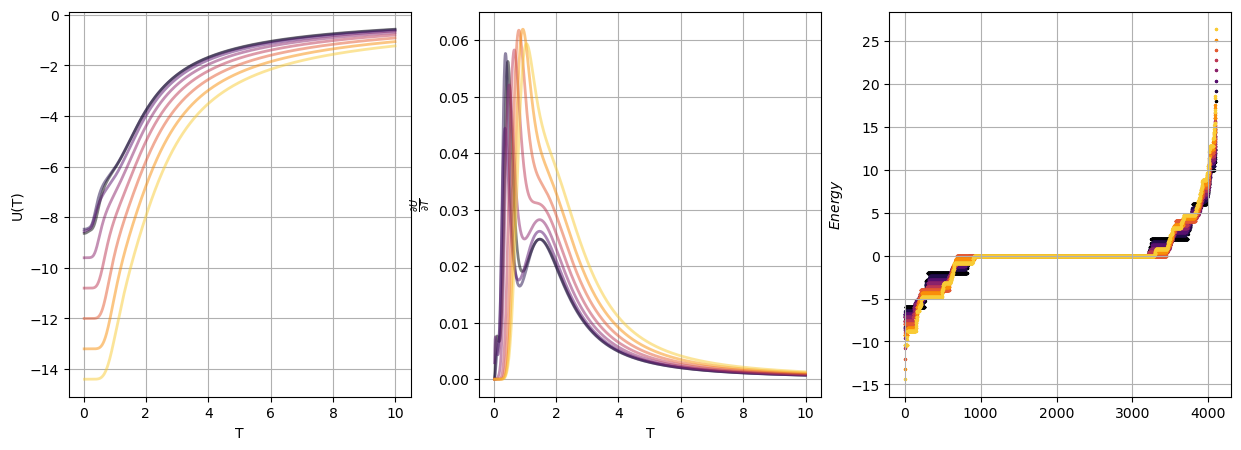

In [159]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


J2 = np.arange(0.,1.5,0.2)

viridis = plt.cm.inferno
colors = [viridis(i/len(J2)) for i in range(len(J2))]
for j1 in range(len(J2)):
    model = Ising_momentum_2layers(6,1,J2[j1],0.5)
    vis(model,ax1,ax2,ax3,colors[j1])

plt.show()